В данном задании требуется на базе для чат-бота сравнить модель seq2seq и seq2seq с вниманием


In [194]:
# Импортируем слои
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional, Embedding, Input, Concatenate, Attention
# Импортируем модели
from tensorflow.keras.models import Sequential, Model, load_model
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer
# Импортируем pad_sequences для ограничения последовательностей заданной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Импортируем методы для отображения модели и преобразования в ОНЕ
from tensorflow.keras.utils import to_categorical, plot_model
# Импортируем оптимизаторы
from tensorflow.keras.optimizers import RMSprop, Adam
# Импортируем функция для разделения выборок
from sklearn.model_selection import train_test_split
# Импортируем pandas
import pandas as pd
# Импортируем numpy
import numpy as np
# Импортируем matplotlib
import matplotlib.pyplot as plt
# Импортируем re
import re
# Импортируем re
import gdown
# Подключим tensorflow
import tensorflow as tf 
# Подключим функцию потерь
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Подключим модуль для работы с операционной системой
import os 
# Подключим модуль для работы с временем
import time
# Подключим модуль для определения форматирования и местоположения делений на осях графиков
import matplotlib.ticker as ticker 

In [195]:
# Подключаем диск
gdown.download('https://storage.googleapis.com/datasets_ai/Advanced/3_seq2seq/9kdialogs.txt', None, quiet=True)

'9kdialogs.txt'

In [196]:
# Определим переменную с именем файла с датасетом
path_to_file="9kdialogs.txt"

In [197]:
# считываем данные
with open('9kdialogs.txt', 'r') as f:     # Открываем файл на чтение
  text = f.read()                                                               # Читаем весь файл

  # Отпарсим текст, убрав знаки препинания, знаки перевода строки
  text = text.replace('\ufeff', '') 
  text = re.sub(r'[^А-я-]', ' ', text)
text

'- - Как вы можете быть таким уверенным  - Элементарно   - - А что делать будем  - Ждать  - - Надеюсь  не до первой звезды  - Я тоже на это надеюсь   - - За что  - Вы знаете за что   - - Ты что-нибудь понимаешь  - Абсолютно ничего   - - Обсудим это завтра  ладно  - Хорошо   - - Кто услышит  - Кто-кто  Ну твой следователь   - - Что - если  - Так  ничего   - - Ну я пойду  - А  Иди  иди  Постой     - - Может  стоило ее предупредить  - Может   - - А вы тут  что ли  не одна живете  - Нет  я живу здесь не одна   - - В рублях или долларах  - В долларах  конечно   - - А теперь  значит  он уже столичная штучка  - Ну да  А что  ты его знаешь   - - Эй  А на курево тебя можно разорить  - Возьми в столе   - - Что  достали  - Да они кого угодно достанут   - - Ты что  издеваешься  - Ага  А как ты догадался   - - Чего тебе  - Я хотел бы поговорить с дамой   - - А вы  собственно  кто  - А я ее концертмейстер   - - И как мне ее найти  Где она сейчас работает  - Она не работает   - - Печальная история  Е

In [198]:
QnA = text.split('- -')[1:]

In [199]:
QnA[:5]

[' Как вы можете быть таким уверенным  - Элементарно   ',
 ' А что делать будем  - Ждать  ',
 ' Надеюсь  не до первой звезды  - Я тоже на это надеюсь   ',
 ' За что  - Вы знаете за что   ',
 ' Ты что-нибудь понимаешь  - Абсолютно ничего   ']

In [200]:
# Разбиваем диалоги на вопросы и ответы

# Создаем списки для ответов и вопросов
questions = []
answers = []
k = 0                   # Переменная для подсчета ненужных данных
for el in QnA:          # Идем по элементам в базе

  # Используем конструкцию try - except для отработки исключений
  try:
    q, a = el.split('-')            # Делим данные по "-"
    questions.append(q)             # Добавляем вопросы
    answers.append(a)               # Добавляем ответы
  except ValueError:
    k+=1

In [201]:
answers[:5]

[' Элементарно   ',
 ' Ждать  ',
 ' Я тоже на это надеюсь   ',
 ' Вы знаете за что   ',
 ' Хорошо   ']

In [202]:
k # Смотрим сколько данных мы не считали

1137

In [203]:
enc_in = ['<START> '+ q for q in questions] # В данные для энкодера записываем вопросы, добавив каждому в начале тег <START>
decoder_in = ['<START> ' + a for a in answers]   # Для декодера на вход создаем ответы с тегом старта
decoder_out = [a + ' <END>' for a in answers]    # Для декодера на выход создаем ответы с тегом конца

In [204]:
print(enc_in[:5])

['<START>  Как вы можете быть таким уверенным  ', '<START>  А что делать будем  ', '<START>  Надеюсь  не до первой звезды  ', '<START>  За что  ', '<START>  Обсудим это завтра  ладно  ']


In [205]:
decoder_in[:5]

['<START>  Элементарно   ',
 '<START>  Ждать  ',
 '<START>  Я тоже на это надеюсь   ',
 '<START>  Вы знаете за что   ',
 '<START>  Хорошо   ']

In [206]:
decoder_out[:5]

[' Элементарно    <END>',
 ' Ждать   <END>',
 ' Я тоже на это надеюсь    <END>',
 ' Вы знаете за что    <END>',
 ' Хорошо    <END>']

In [207]:
num_words = 10000 # Ограничиваем данные на 10000 слов
tokenizer = Tokenizer(num_words, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<UNK>') # Создаем токенайзер на 10000 слов, с фильтром и токеном неизвестных слов

In [208]:
# Обучаем токенайзре на всех трех текстах, которые мы создали
tokenizer.fit_on_texts(enc_in)
tokenizer.fit_on_texts(decoder_in)
tokenizer.fit_on_texts(decoder_out)

In [209]:
tokenizer.index_word

{1: '<UNK>',
 2: '<start>',
 3: '<end>',
 4: 'не',
 5: 'что',
 6: 'да',
 7: 'я',
 8: 'а',
 9: 'ты',
 10: 'в',
 11: 'нет',
 12: 'это',
 13: 'вы',
 14: 'как',
 15: 'и',
 16: 'на',
 17: 'ну',
 18: 'с',
 19: 'у',
 20: 'так',
 21: 'где',
 22: 'же',
 23: 'он',
 24: 'все',
 25: 'кто',
 26: 'знаю',
 27: 'мне',
 28: 'меня',
 29: 'там',
 30: 'ничего',
 31: 'есть',
 32: 'конечно',
 33: 'за',
 34: 'тебя',
 35: 'тебе',
 36: 'вас',
 37: 'еще',
 38: 'куда',
 39: 'чего',
 40: 'мы',
 41: 'здесь',
 42: 'вам',
 43: 'она',
 44: 'вот',
 45: 'сейчас',
 46: 'можно',
 47: 'почему',
 48: 'его',
 49: 'может',
 50: 'надо',
 51: 'чем',
 52: 'зачем',
 53: 'только',
 54: 'к',
 55: 'о',
 56: 'тут',
 57: 'очень',
 58: 'бы',
 59: 'ли',
 60: 'сколько',
 61: 'ее',
 62: 'они',
 63: 'из',
 64: 'по',
 65: 'если',
 66: 'но',
 67: 'уже',
 68: 'хорошо',
 69: 'то',
 70: 'случилось',
 71: 'кого',
 72: 'хочешь',
 73: 'нас',
 74: 'спасибо',
 75: 'от',
 76: 'ага',
 77: 'просто',
 78: 'или',
 79: 'когда',
 80: 'пока',
 81: 'дело',


In [210]:
# Преобразуем слова в последовательность индексов
X_enc = tokenizer.texts_to_sequences(enc_in) 
X_dec = tokenizer.texts_to_sequences(decoder_in)
Y = tokenizer.texts_to_sequences(decoder_out)

In [211]:
X_enc[:5]

[[2, 14, 13, 279, 86, 1006, 6548],
 [2, 8, 5, 99, 142],
 [2, 451, 4, 111, 2355, 3051],
 [2, 33, 5],
 [2, 6549, 12, 187, 122]]

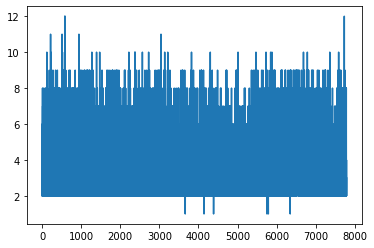

In [212]:
# посмотрим на длину фраз в массиве Y
len_Y=[]
for i in Y:
  len_Y.append(len(i))
plt.plot(len_Y)

In [213]:
threshold = 15                         # Задаем порог
idx = [len(y) < threshold for y in Y]  # Удаляем предложения, длина которых больше заданного порога

In [214]:
sum(idx) # Проверяем количество оставшихся предложений

7791

In [215]:
max_q_len = max([len(el) for el in X_enc]); max_q_len # максимальная длина вопросов

11

In [216]:
max_a_len = max([len(el) for el in X_dec]); max_a_len # максимальная длина ответов

12

In [217]:
# Выравниваем размеры векторов для вопросов/ответов
X_enc = pad_sequences(X_enc, max_q_len, padding='post', truncating='post')
X_dec = pad_sequences(X_dec, max_a_len, padding='post', truncating='post')
Y = pad_sequences(Y, max_a_len, padding='post', truncating='post')

In [218]:
# Оставляем предложения, длина которых меньше заданного порога
X_enc = X_enc[idx] 
X_dec = X_dec[idx]
Y = Y[idx]

In [219]:
hidden_dim = 256 # размер скрытого пространства

In [220]:
# Создаем энкодер
encoder_input = Input((None,))                                                  # Создаем входной слой для энкодера
enc_emb = Embedding(num_words, hidden_dim)(encoder_input)                       # Создаем Embedding слоя на количество слов num_words 
_, *states = LSTM(hidden_dim, return_state=True)(enc_emb)                       # LSTM возвращает элементы y, h, c

encoder = Model(encoder_input, states)                                          # Собираем модель энкодера

# Создаем декодер
decoder_input = Input((None,))                                                                        # Создаем входнйо слой для декодера
dec_emb = Embedding(num_words, hidden_dim, name='emb')(decoder_input)                                 # Создаем Embedding слоя на количество слов num_words 
dec_lstm = LSTM(hidden_dim, return_sequences=True, name='lstm1')(dec_emb, initial_state = states)     # Создаем LSTM - слой
dec_out = Dense(num_words, activation='softmax', name='dense')(dec_lstm)                              # Выходной слой на количество num_words

# Собираем модель целиком
seq2seq = Model([encoder_input, decoder_input], dec_out)

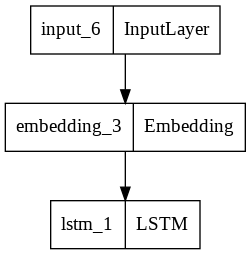

In [221]:
plot_model(encoder) # Выводим модель энкодера

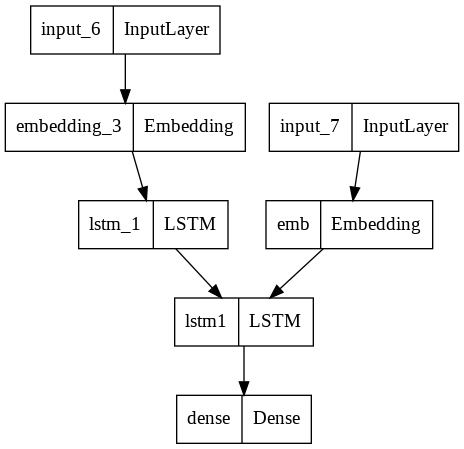

In [222]:
plot_model(seq2seq) # Выводим всю модель

In [223]:
# Компилируем модель с такими лосом, оптимизатором и метрикой
seq2seq.compile(loss="sparse_categorical_crossentropy", optimizer='RMSProp', metrics=['sparse_categorical_accuracy'])

In [ ]:
# Выводим summary модели
seq2seq.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2560000     ['input_1[0][0]']                
                                                                                                  
 emb (Embedding)                (None, None, 256)    2560000     ['input_2[0][0]']                
                                                                                            

In [ ]:
# Обучаем модель
seq2seq.fit([X_enc, X_dec], Y, batch_size=30, epochs=30, validation_split=0.2)

Epoch 1/30
208/208 [==============================] - 25s 55ms/step - loss: 2.1645 - sparse_categorical_accuracy: 0.7398 - val_loss: 1.9397 - val_sparse_categorical_accuracy: 0.7589
Epoch 2/30
208/208 [==============================] - 8s 39ms/step - loss: 1.8095 - sparse_categorical_accuracy: 0.7637 - val_loss: 1.9148 - val_sparse_categorical_accuracy: 0.7588
Epoch 3/30
208/208 [==============================] - 6s 31ms/step - loss: 1.7558 - sparse_categorical_accuracy: 0.7652 - val_loss: 1.8994 - val_sparse_categorical_accuracy: 0.7620
Epoch 4/30
208/208 [==============================] - 6s 30ms/step - loss: 1.7178 - sparse_categorical_accuracy: 0.7659 - val_loss: 1.9076 - val_sparse_categorical_accuracy: 0.7614
Epoch 5/30
208/208 [==============================] - 6s 30ms/step - loss: 1.6886 - sparse_categorical_accuracy: 0.7662 - val_loss: 1.9086 - val_sparse_categorical_accuracy: 0.7621
Epoch 6/30
208/208 [==============================] - 6s 30ms/step - loss: 1.6600 - sparse_cat

In [ ]:
# Задаём входные слои
decoder_input = Input((None,))
h_input = Input((hidden_dim,))
c_input = Input((hidden_dim,))

states = [h_input, c_input] # Собираем вместе 2 вектора состояния
dec_emb = Embedding(num_words, hidden_dim, weights=seq2seq.get_layer(name='emb').get_weights(), name='emb')(decoder_input)                                # Создаем Embedding-слой, которому дополнительно указываем весовые коэффициенты для слоя с указанным именем в модели seq2seq
lstm, h, c = LSTM(hidden_dim, return_state=True, weights=seq2seq.get_layer(name='lstm1').get_weights(), name='lstm1')(dec_emb, initial_state=states)      # Создаем LSTM-слой, которому дополнительно указываем весовые коэффициенты для слоя с указанным именем в модели seq2seq
out = Dense(num_words, activation='softmax', weights=seq2seq.get_layer(name='dense').get_weights(), name='dense')(lstm)                                   # Создаем Dense-слой, которому дополнительно указываем весовые коэффициенты для слоя с указанным именем в модели seq2seq

decoder = Model([decoder_input]+states, [out, h, c]) # Собираем декодер

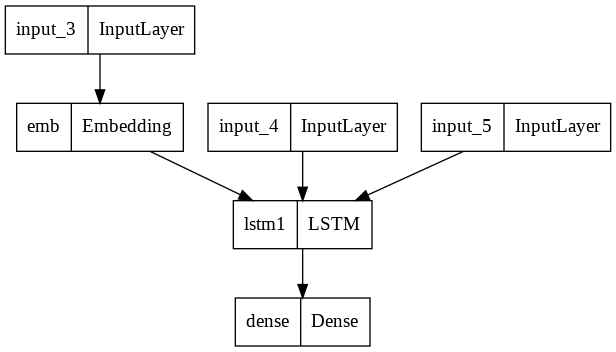

In [ ]:
plot_model(decoder)

In [ ]:
def decode_sequence(input_seq):


  '''
  Функция обработки предложения и предсказывания результата через декодер

  Args:
    input_seq - входное предложение формата str
    
  Returns:
    Вовзращает предложение, получившееся  после обработки input_seq через нашу модель
  '''

  states = encoder.predict(input_seq)                                           # возвращаем состояние [h, c]
  prev_token = np.zeros((1,1))                                                  # создаем элемент с 0 для начального токена
  prev_token[0,0] = tokenizer.word_index['<start>']                             # присваиваем первому символу "старт"

  Flag = False                                                                  # флаг остановки
  decoded_sentence = ''                                                         # обнуляем слово

 
  while not Flag:                                                               # Запускаем цикл для предсказания следующего состояния
    pred, *states= decoder.predict([prev_token] + states)                       # Предсказываем состояние с учетом предыдущих итераций  
    next_token = np.argmax(pred, axis=-1)                                       # переводим декодированный токен в символ
    sampled_word = tokenizer.sequences_to_texts([next_token])[0]                # Переводим последовательность в текст
    
    decoded_sentence += sampled_word +' '                                       # Все присваиваем decoded_sentence

    # Если в слове находим последний символ или превысили длину слова, то завершаем работу
    if (sampled_word == '<end>' or
      len(decoded_sentence) > max_a_len+1):
      print(pred.shape)
      Flag = True

    prev_token[0,0] = next_token 

  return decoded_sentence                                                       # Возвращаем предложение

In [ ]:
sent = input('Введите предложение: ')  # Вручную вводим фразу
sent = '<start> ' + sent               # Добавляем тег старта
x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_q_len, padding='post', truncating='post') # Выравниваем предложение
print(decode_sequence(x))              # Восстанавливаем предскзаание

Введите предложение: как настроение
(1, 10000)
как в чем это 


In [ ]:
for _ in range(6):
  sent = input('Введите предложение: ')  # Вручную вводим фразу
  sent = '<start> ' + sent               # Добавляем тег старта
  x = pad_sequences(tokenizer.texts_to_sequences([sent]), maxlen=max_q_len, padding='post', truncating='post') # Выравниваем предложение
  print(decode_sequence(x))              # Восстанавливаем предскзаание

Введите предложение: куда сходить вечером
(1, 10000)
в волнуйтесь <end> 
Введите предложение: как дела
(1, 10000)
нормально <end> 
Введите предложение: зачем это нужно
(1, 10000)
это мой как <end> 
Введите предложение: как пройти в библиотеку
(1, 10000)
надо же она <end> 
Введите предложение: почему зимой снег
(1, 10000)
потому что так 
Введите предложение: куда делись динозавры
(1, 10000)
из него <end> 


прямо скажем, обучился наш чат-бот так себе. Попробуем обучить сеть с вниманием.

In [270]:
questions_SS = ['<START> '+ q + '<STOP> ' for q in questions] # В данные для энкодера записываем вопросы, добавив каждому в начале тег <START>
answers_SS = ['<START> ' + a + '<STOP> ' for a in answers]   # Для декодера на вход создаем ответы с тегом старта

In [271]:
questions_SS[:5]

['<START>  Как вы можете быть таким уверенным  <STOP> ',
 '<START>  А что делать будем  <STOP> ',
 '<START>  Надеюсь  не до первой звезды  <STOP> ',
 '<START>  За что  <STOP> ',
 '<START>  Обсудим это завтра  ладно  <STOP> ']

In [272]:
# Создадим мини-функцию, возвращающую максимальную длину тензора
def max_length(tensor):                                   # Функция принимает на вход тензор(фразы в виде последовательности индексов)

  # Вернем значение максимальной длины его элемента 
  return max(len(t) for t in tensor) 

In [273]:
def tokenize(language): # Функция принимает текст вопросов или ответов

  language_tokenizer = Tokenizer(filters='', oov_token='<UNK>')               # Вызываем класс Токенизатор, просим его не удалять символы, которые он удаляет по умолчанию
  language_tokenizer.fit_on_texts(language)                # "скармливаем" ему тексты для обработки и сборки словаря частотности
  tensor = language_tokenizer.texts_to_sequences(language) # Разбиваем текст фраз на последовательности индексов
  tensor = pad_sequences(tensor, padding='post')           # Делаем последовательности фиксированной длины, заполняя нулями более короткие фразы

  # Возвращаем последовательность индексов(назовем ее тензор) и токенизатор
  return tensor, language_tokenizer 

In [274]:
def load_dataset(quest, answ,               # вопросы и ответы
                 num_examples=None):        # Необходимый объем датасета

    # Из исходного текста делаем датасет пар фраз, причём входным языком для сети сделаем русский
    #targ_language, inp_language = create_dataset(path, num_examples)

    # Разбиваем текст на последовательность индексов(назовем ее тензор)
    input_tensor, inp_language_tokenizer = tokenize(quest)    # Формируем тензоры и токенизатор для вопросов
    target_tensor, targ_language_tokenizer = tokenize(answ) # Формируем тензоры и токенизатор для ответов

    # Функция вернёт: тензор для вопросов, для ответов; токенизаторы для вопросов и ответов
    return input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer

In [275]:
input_tensor, target_tensor, inp_language_tokenizer, targ_language_tokenizer = load_dataset(questions_SS, answers_SS)

# Вычислим максимальные длины тензоров для вопросов и ответов, используя ранее заданную функцию
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Создаем тренировочную и тестовую выборки по формуле 80/20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [276]:
# получились вот такие наборы тензоров
input_tensor_train.shape

(6232, 12)

In [277]:
# Визуализируем собранные данные

def convert(language_tokenizer,  # Токенайзер
            tensor):             # Список индексов слов
            
  #  Цикл по токенам во фразе
  for t in tensor:  
    if t!=0:                                                        # Если токен не 0. Т.е. не нули в конце фразы
      print ("%d ----> %s" % (t, language_tokenizer.index_word[t])) # Выводи токен и соответствующее слово

Посмотрим на примеры В первом блоке выведем вопрос и его токен Во втором ответ.

Далее выводим статистику по датасету

In [278]:
print ("Вопрос; соответствие индекса и слова")   
convert(inp_language_tokenizer, input_tensor_train[0])           # Выведем нулевую пару из русского датасета
print ()    

print ("Ответ; соответствие индекса и слова")
convert(targ_language_tokenizer, target_tensor_train[0])         # Выведем нулевую пару из агнлийского датасета
print ()   
                                                      
print("Вопрос тренировочная: " , len(input_tensor_train), "фраз; ", "Ответ тренировочная: ", len(target_tensor_train), "фраз")# Выведем статистику по обучающей выборке
print("Вопрос тестовая: ", len(input_tensor_val), "фраз; ", "Ответ тестовая: ", len(target_tensor_val), "фраз")               # Выведем статистику по тестовой выборке

Вопрос; соответствие индекса и слова
2 ----> <start>
10 ----> как
7 ----> вы
9 ----> не
71 ----> знаете
719 ----> свое
280 ----> имя
3 ----> <stop>

Ответ; соответствие индекса и слова
2 ----> <start>
23 ----> ничего
4 ----> не
15 ----> знаю
3 ----> <stop>

Вопрос тренировочная:  6232 фраз;  Ответ тренировочная:  6232 фраз
Вопрос тестовая:  1559 фраз;  Ответ тестовая:  1559 фраз


Создаем tf.data датасет (Раздел tf.data.Dataset API предлагает построить готовый конвейер для обучения моделей)

In [279]:
# Определим постоянные 

BUFFER_SIZE = len(input_tensor_train)                     # Укажем что случайно сэмплировать будем по всей длине обучающейся выборки
BATCH_SIZE = 256                                          # Указываем размер батча
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE     # Укажем количество шагов в одной эпохе
embedding_dim = 256                                       # Размерность эмбеддинга, векторного пространства
units = 1024                                              # Задаем размер слоя(количество нейронов в слое) 

In [280]:
# Задаем размер словаря с вопросами
vocab_inp_size = len(inp_language_tokenizer.word_index)+1 

# Задаем размер словаря с ответами
vocab_tar_size = len(targ_language_tokenizer.word_index)+1 

# Создаём датасет из массивов Numpy(вопросы и ответы тренировочные фразы) со случайной подачей тренировочных сэмплов в процессе обучения
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)

# Передаем в датасет размер батча и указываем, что если в тренировке последний батч окажется неполным, то опустим его
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [281]:
# Посмотрим на форму примеров полученных батчей

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 12]), TensorShape([256, 13]))

Вспомним нашу схему - сеть состоит их кодера, декодера и блока attention.

Оформим кодер в виде класса. В данном случае кодер состоит из блоков Embedding и GRU. Обратим внимание на return_sequences=True, return_state=True - мы требуем состояния кодера на каждом шаге работы.

На вход принимает вопрос и начальное состояние. Отдает выход GRU и вектор скрытых состояний

In [282]:
class Encoder(Model):

  # Конструктор класса 
  def __init__(self, 
               vocab_size,    # Размер словаря
               embedding_dim, # Размер пространсва эмбеддинга
               enc_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча

    super(Encoder, self).__init__()                                   # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                                          # Атрибут возвращает размер батча
    self.enc_units = enc_units                                        # Атрибут возвращает размер слоя в кодировщике
    self.embedding = Embedding(vocab_size, embedding_dim)             # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и с dim=256

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки
    self.gru = GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

  # Метод принимает входную фразу и начальное состояние
  def call(self, 
           x,       # Входная фраза
           hidden): # Начальное энкодера
    x = self.embedding(x) # входящие тензоры преобразовываются в эмбеддинг
    output, state = self.gru(x, initial_state = hidden) #затем пропускаются через GRU и получаем выход + новое состояние

    # Выход сети GRU и состояние на выходе
    return output, state 

  # Создаем метод инициализации состояний на скрытых слоях
  def initialize_hidden_state(self):

    # Вернем тензор из нулей размер батча на размер слоя, итсполбьзуем как начальное состояние энкодера
    return tf.zeros((self.batch_sz, self.enc_units)) 

Создаем экземпляр класса Encoder. Используем далее как готовый модуль при построении модели сети

In [283]:
# Создадим модель кодировщика по уже заданным параметрам 
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [284]:
# Подадим в качестве примера какой-то сэмпл(Тензор[64, 12]) на вход Encoder'у и визуализируем, что получим
sample_hidden = encoder.initialize_hidden_state() #инициализируем начальное скрытое состояние

# Даем Encoder'у сэмпл и начальное состояние, и получим выход из сети GRU и состояние на выходе (вызывается метод call класса Encoder)
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Размеры выхода из кодировщика: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Размеры скрытого состояния: (batch size, units) {}'.format(sample_hidden.shape))

Размеры выхода из кодировщика: (batch size, sequence length, units) (256, 12, 1024)
Размеры скрытого состояния: (batch size, units) (256, 1024)


Создадим класс модуля attenton, как предписывал Bahdanau. На входе состояния кодера hidden_state и values - выход предыдущего декодера с предыдущего шага. На выходе вектор контекста и веса attention:

In [285]:
class BahdanauAttention(Model): # Название класса именем создателя механизма Дмитрия Богданова(Bahdanau)

  # Создаем конструктор класса
  def __init__(self, 
               units):                        # Число нейронов 

    super(BahdanauAttention, self).__init__() # Даем возможность использовать и исполнять методы класса-родителя в классе потомке
    self.W1 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.W2 = Dense(units)                    # Создаем Dense с заданным числом нейронов
    self.V =  Dense(1)                        # Создаем Dense с числом нейронов =1

  # Метод принимает состояние и выход энкодера ----------------------------------
  
  def call(self, 
           hidden_state, # Состояние энкодера
           values):      # Выход энкодера
    # Форма состояния на скрытом слое (batch_size, hidden size)
    # Форму состояния на каждом такте увеличим до (batch_size, 1, hidden size)
    # Добавляем это для того, чтобы получить оценку
    hidden_with_time_axis = tf.expand_dims(hidden_state, 1)

    # Форма оценки score (размер батча, макс.длина слов на входе, 1), однёрка в конце, чтобы применить self.V
    # До применения self.V оценка была бы (размер батча, макс.длина слов на входе, количество нейронов в слое)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # К полученной оценке применим Софтмакс, который покажет вероятность полезности от 0 до 1 для каждого слова в фразе для декодера
    # Форма оценки score - (размер батча, макс.длина слов на входе, 1); Софтмакс применяем к оси "макс.длина слов"
    attention_weights = tf.nn.softmax(score, axis=1)

    # Построим вектор контекста 
    context_vector = attention_weights * values # Веса внимания перемножим со значениями(выхода из кодировщика)
    # Сумму также применяем по оси "макс.длина слов на входе"
    context_vector = tf.reduce_sum(context_vector, axis=1) # Размеры вектора контекста после суммирования будут (размер батча, размер слоя)

    # Возвращает вектор контекста и веса внимания
    return context_vector, attention_weights


Создадим экземпляр класса BahdanauAttention. Здесь 10 - число нейронов в первом dense слое

In [286]:
# Проверим, как работает слой
attention_layer = BahdanauAttention(10)

# Подадим на вход слою внимания выход из Encodera и его состояние, и получим значение и веса внимания
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Размеры значения внимания: (размер батча, размер слоя) {}".format(attention_result.shape))
print("Размеры весов внимания: (размер батча, длина последовательности, 1) {}".format(attention_weights.shape))

Размеры значения внимания: (размер батча, размер слоя) (256, 1024)
Размеры весов внимания: (размер батча, длина последовательности, 1) (256, 12, 1)


Создаем класс декодера с attention. Декодер принимает обущающую фразу, прогоняет через embedding. Далее склеивает с вектором контента и подает на GRU. На выходе dense слой с числом нейронов равному размеру словаря.

In [287]:
class Decoder(Model):

  # Создадим конструктор класса
  def __init__(self,   
               vocab_size,    # Размер словаря
               embedding_dim, # Размерность пространства эмбеддинга
               dec_units,     # Число нейронов в GRU
               batch_sz):     # Размер батча
    super(Decoder, self).__init__()                       # Даем возможность использовать и исполнять методы класса-родителя в классе потомке 
    self.batch_sz = batch_sz                              # Атрибут возвращает размер батча
    self.dec_units = dec_units                            # Атрибут возвращает размер слоя в декодере(кол-во нейронов)
    self.embedding = Embedding(vocab_size, embedding_dim) # Атрибут эмбеддинга - слой Кераса с размером словаря на входе и (dim=256) на выходе

    # Реккурентной сетью выберем GRU, указываем размер слоя, вывод из слоя в виде последовательностей, 
    # и метод инициализации весов 'glorot_uniform'(или метод Ксавьера) для упрощения прохождения сигнала при распростр-ии ошибки    
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')

    self.fc = Dense(vocab_size) # Атрибут вызовет полносвязный слой с размером словаря

    self.attention = BahdanauAttention(self.dec_units) #атрибут подключит механизм внимания, описанный ранее


  def call(self, 
           x,           # Начальный токен
           hidden,      # Состояние  энкодера
           enc_output): # Выход энкодера

    # Enc_output размеры (batch_size, max_length, hidden_size - размер батча, макс.длина фраз, разм.скр.слоя)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # Входящий тензор слова пропускаем через эмбеддинг (получаем размеры batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # Дальше конкатенируем с вектором контекста (получаем размеры batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # Сконкатенированный вектор передаем  в GRU и получаем выход с декодера и состояние
    output, state = self.gru(x)

    # Output размеры (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # Пропускаем через полносвязный слой
    x = self.fc(output) #output размеры (batch_size, vocab)

    # Вернем выходную фразу, вектор состояния, веса внимания
    return x, state, attention_weights

In [288]:
# Проверим работу декодера, подав на вход случайный массив с нужной размерностью
# Создали декодер с параметрами(размер словаря с ответами, размерность эмбеддинга, кол-во нейронов, размер батча)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Подаём на вход случайный массив с нужной размерностью, состояние и выход с кодировщика
sample_decoder_output, _, _ = decoder(tf.random.uniform((256, 1)), sample_hidden, sample_output)
print ('Размер выхода с декодера: (размер батча, размер словаря) {}'.format(sample_decoder_output.shape))

Размер выхода с декодера: (размер батча, размер словаря) (256, 5830)


In [289]:
# Выбираем оптимайзер Adam
optimizer = Adam() 

Наша функция потерь называется loss_function - сначала она уберет из расчетов нулевые элементы в истинной и предсказанной фразе.

Длина фразы может быть меньше максимально допустимой или фраза может быть сформирована не полностью. Просто не будем учитывать мусор в конце фразы.

Далее применим стандартную для Kerasa функцию потерь SparseCategoricalCrossentropy. По сравнению CategoricalCrossentropy работает также, но позволяет нам не хранить слова в виде OneHotEncoding, что существенно экономить память.

На выходе получаем среднее значение потерь:

In [290]:
# Используем SparseCategoricalCrossentropy, к-я может работать с некатегориальными лейблами
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none') # Выбираем функцию потерь

def loss_function(real, pred):                       # Запишем функцию потерь, на вход подаем фактический и предсказанный результат
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # Найдем маску, которая уберет нулевые значения индексов в конце фразы
  loss_ = loss_object(real, pred)                    # Фактические и предсказанные результаты передаем в SparseCategoricalCrossentropy и получаем ошибку
  mask = tf.cast(mask, dtype=loss_.dtype)            # Согласуем тип маски с типом потерь
  loss_ *= mask                                      # Накидываем "маску" которая оставит для работы ненулевые значения
  
  # Вернем reduce_mean - среднее любого выбранного тензора
  return tf.reduce_mean(loss_)

In [291]:
# Сохраняем процесс обучения модели чекпоинтами тензорфлоу

checkpoint_dir = './training_checkpoints'                                               # Даем ссылку на директорию
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")                                # Добавляем префикс "ckpt"
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder) # Сохраняем состояния/показатели оптимизатора и моделей

Создадим функцию для обучения модели. На входе - исходная фраза, конечная фраза, начальное состояния кодера. Подаем сразу батчем. На выходе потери на этом батче

In [292]:
@tf.function
def train_step(inp,         # Входная фраза
               targ,        # ответ на фразу
               enc_hidden): # Состояния энкодера

  # Создаем переменную, в которую будем записывать ошибку
  loss = 0                             

  # Все операции по вычислению градиента записываются на ленту(tape) и мы получаем к ним доступ
  with tf.GradientTape() as tape:

    # Передаем тензор и начальное состояние в кодировщик и получим выход и состояние на выходе
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # Передадим это состояние декодеру
    dec_hidden = enc_hidden

    # Передаем в качестве входа в декодер индекс токена "<start>"
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Техника "Teacher forcing" - подаем предыдущее выходное слово на вход следущего в декодере. Targ.shape[64, 9]

    for t in range(1, targ.shape[1]): #для каждого слова из английской фразы

      # Передаем в обработку декодеру начальный токен, состояние на выходе из кодера, и выход из кодера
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # Получаем от декодера предсказание и обновленное состояние

      # Обновляем ошибку для текущих предсказаний
      loss += loss_function(targ[:, t], predictions)

      # Используем "Teacher forcing"
      dec_input = tf.expand_dims(targ[:, t], 1)

  # Получаем ошибку на батче . Targ.shape[64, 9]. Делим на 9
  batch_loss = (loss / int(targ.shape[1])) 

  # Создаем список переменных, для которых TensorFlow будет вычислять градиенты
  variables = encoder.trainable_variables + decoder.trainable_variables # создаем переменные, для которых TensorFlow будет вычислять градиенты

  # Отслеживаем градиент
  gradients = tape.gradient(loss, variables)

  # Корректируем веса
  optimizer.apply_gradients(zip(gradients, variables))

  # Функция обучения вернет ошибку на батче
  return batch_loss

Обучаем сеть. 30 эпох. На каждой эпохе прогоняем весь набор данных через функцию обучения. Считаем лоссы. Сохраняем статистику каждые 10 эпох

In [293]:
EPOCHS = 30 # устанавливаем количество эпох

for epoch in range(EPOCHS): # Цикл по каждой эпохе
  start = time.time() # Запомним время начала эпохи

  progbar = tf.keras.utils.Progbar(target=steps_per_epoch, stateful_metrics=[
                                     'batch_loss'], unit_name='batch')        # Создадим индикатор прогресс обучения

  enc_hidden = encoder.initialize_hidden_state() # Задаем начальное состояние на скрытом слое encodera 
  total_loss = 0                                 # Начальное значение итоговой ошибки

  # Для батча, входного и выходного тензора на каждом шаге эпохи
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden) # Передадим в функцию тензоры и состояние в кодировщике, обучим и получим ошибку на батче
    total_loss += batch_loss                       # Добавим ее в итоговую ошибку
    progbar.update(                                # Обновим состояние индикатора обучения
            batch + 1, values=[('batch_loss', batch_loss)])


  # Каждые 10 эпох будем сохранять чекпоинты
  if (epoch + 1) % 10 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Выведем показатели после каждой эпохи
  print('Эпоха {} Ошибка {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch)) # Выведем номер эпохи и потери
  print('Время на 1 эпоху {} сек'.format(round(time.time() - start), 1))          # Выведем длительность обучения этой эпохи

24/24 [==============================] - 33s 412ms/batch - batch_loss: 1.7334
Эпоха 1 Ошибка 2.0166
Время на 1 эпоху 41 сек
24/24 [==============================] - 10s 405ms/batch - batch_loss: 1.7134
Эпоха 2 Ошибка 1.7154
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 428ms/batch - batch_loss: 1.6675
Эпоха 3 Ошибка 1.6430
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 421ms/batch - batch_loss: 1.5924
Эпоха 4 Ошибка 1.5999
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 421ms/batch - batch_loss: 1.6261
Эпоха 5 Ошибка 1.5667
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 418ms/batch - batch_loss: 1.6158
Эпоха 6 Ошибка 1.5381
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 432ms/batch - batch_loss: 1.5275
Эпоха 7 Ошибка 1.5110
Время на 1 эпоху 10 сек
24/24 [==============================] - 10s 418ms/batch - batch_loss: 1.5219
Эпоха 8 Ошибка 1.4857
Время на 1 эпоху 10 сек
24/24 [=

Данная функция собирает модель кодера, декодера и attention для работы в режиме предсказания.

На входе вопрос, на выходе ответ на него

In [297]:
def evaluate(sentence):

    # Создаем начальные настройки графика внимания
    attention_plot = np.zeros((max_length_targ, max_length_inp)) 
    
    # Предобрабатываем предложение
    sentence = preprocess_sentence(sentence) 

    inputs = [inp_language_tokenizer.word_index[i] for i in sentence.split(' ')]   # Преобразовываем в послед-ть индексов
    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post')        # Делаем паддинг
    inputs = tf.convert_to_tensor(inputs)                                          # Конвертируем в тф тензор

    result = ''                                                                    # Сюда запишем результат

    hidden = [tf.zeros((1, units))]                                                # Задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden)                                  # Передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden                                                        # Состояние кодера передаем в декодер
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']], 0) # Передаем на вход декодеру <start> в виде индекса

    for t in range(max_length_targ):                                               # Идем по макс.длине фраз ответов
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Сохраняем веса внимания для графика
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # Аргмаксом вытаскиваем предсказанное слово
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Результат конвертируем из индекса в слово и сохраняем в result = ''
        result += targ_language_tokenizer.index_word[predicted_id] + ' '

        # Если предсказанное слово - <end>, то останавливаемся, возвращаем результаты, выводим на графике
        if targ_language_tokenizer.index_word[predicted_id] == '<stop>':
            return result, sentence, attention_plot

        # Педсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    # Вернем перевод, входную фразу и веса внимания
    return result, sentence, attention_plot

Нам интересно как связаны слова в исходной фразе и в ответе на нее. Функция отрисовывает веса внимания в виде 2D матрицы, соотносит каждую пару слов ее весом

In [298]:
def plot_attention(attention,           # Веса внимания
                   sentence,            # Исходная фраза
                   predicted_sentence): # Предсказаные перевод
  
    fig = plt.figure(figsize=(10,10))                                   # Зададим размер 
    ax = fig.add_subplot(1, 1, 1)                                       # Добавим 1 картинку
    ax.matshow(attention, cmap='viridis')                               # Нарисуем 2d матрицу
    fontdict = {'fontsize': 14}                                         # Зададим размер надписей
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90) # Добавим надпись по горизонтальной оси
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)    # Добавим надпись по вертикальной оси
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))               # Зададим форматирование делений на осях графиков
    plt.show()                                                          # Отрисуем изображение

Соберем написанные ранее функции вместе. Будем переводить фразы и строить матрицы внимания(attention) - смотреть связи слов в предложении

Создадим функцию для перевода фраз с визуализацией матрицы внимания

In [299]:
def preprocess_sentence(phrases): # Функция принимает содержимое словаря

  # Разделяем пробелами слова и знаки препинания("А как насчет тебя? " -> "А как насчет тебя ? ") 
  phrases = re.sub(r"([?.!,;:])", r" \1 ", phrases) # r" \1 " берёт значения 1й группы в скобках; обрамляем указанные символы пробелами

  # Заменяем всё на пробелы, за исключением (a-zA-Zа-яёА-ЯЁ?.!,;:)
  phrases = re.sub(r"[^а-яёА-ЯЁ?.!,;:]+", " ", phrases) 
  
  # Получаем строку без случайных лишних пробелов в конце фраз(rstrip удаляет с конца строки)
  phrases = phrases.rstrip().strip()      

  # Для нашей модели обозначим тегами начало и конец предложения  
  phrases = '<start> ' + phrases  #+ '<STOP> ' 

  # Функция возвращает предобработанные фразы
  return phrases 

In [300]:
def translate(sentence): # Функция принимает предложение и выводит результат с визуализацией
    result, sentence, attention_plot = evaluate(sentence)  # Отдадим фразу. Получим перевод, входную фразу,  веса внимания

    print('Входящая фраза: %s' % (sentence))          # Выведем входную фразу 
    print('Предсказанный ответ на нее: {}'.format(result)) # Выведем полученный перевод

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))] # Возьмем весы внимания, только для слов во фразах. Хвосты не смотрим
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))              # Выведем веса внимания

In [301]:
# Воспроизведём последний сохранённый чекпоинт
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

И, наконец, ответим на входную фразу и выведем визуализацию

Входящая фраза: <start> зачем куда то идти
Предсказанный ответ на нее: в кабинет <stop> 


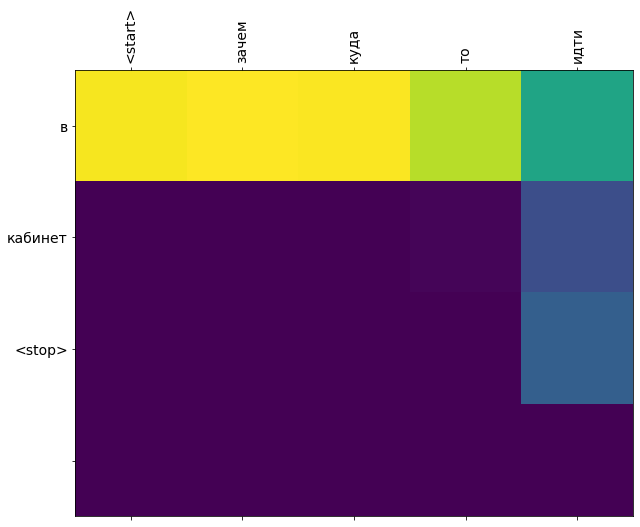

In [302]:
translate('зачем куда-то идти')

In [380]:
# попытка номер 3
def evaluate_without_plot(sentence):
    
    # Предобрабатываем предложение
    sentence = preprocess_sentence(sentence) 
    sentence=sentence.split(' ')
    inputs=[]
    for i in sentence:
      try:
        inputs.append(inp_language_tokenizer.word_index[i])
      except:
        #print ("а вот спросите меня о чем-нить полезном: ")  # Выдадим дежурную фразу
        break 

    inputs = pad_sequences([inputs], maxlen=max_length_inp, padding='post')        # Делаем паддинг
    inputs = tf.convert_to_tensor(inputs)                                          # Конвертируем в тф тензор

    result = ''                                                                    # Сюда запишем результат

    hidden = [tf.zeros((1, units))]                                                # Задаем начальное состояние
    enc_out, enc_hidden = encoder(inputs, hidden)                                  # Передаем его и входной тензор и получаем выход с кодера и состояние

    dec_hidden = enc_hidden                                                        # Состояние кодера передаем в декодер
    dec_input = tf.expand_dims([targ_language_tokenizer.word_index['<start>']], 0) # Передаем на вход декодеру <start> в виде индекса

    for t in range(max_length_targ):                                               # Идем по макс.длине фраз ответов
        # Прогоняем через декодер входящий тензор, состояние с выхода кодера, выход с кодера
        # Получаем результат предсказания, обновленное состояние, и веса внимания
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # Аргмаксом вытаскиваем предсказанное слово
        predicted_id = tf.argmax(predictions[0]).numpy()

        # Результат конвертируем из индекса в слово и сохраняем в result = ''
        result += targ_language_tokenizer.index_word[predicted_id] + ' '

        # Если предсказанное слово - <stop>, то останавливаемся, возвращаем результаты
        if targ_language_tokenizer.index_word[predicted_id] == '<stop>':
            return result, sentence

        # Педсказанное значение подается обратно в модель
        dec_input = tf.expand_dims([predicted_id], 0)

    # Вернем перевод, входную фразу и веса внимания
    return result, #sentence #, attention_plot

In [381]:
def translate_without_plot(sentence): # Функция принимает предложение и выводит результат с визуализацией
    result, sentence = evaluate_without_plot(sentence)  # Отдадим вопрос. Получим ответ, входную фразу

    #print('Входящая фраза: %s' % (sentence[1:]))          # Выведем входную фразу 
    print('Предсказанный ответ на нее: {}'.format(result[:-7])) # Выведем полученный ответ

Посмотрим, что умеет наш бот. Зададим ему вопросы и оценим ответы

In [382]:
for fr in range(6):
  fr=input()
  translate_without_plot(fr)

что в сумке
Предсказанный ответ на нее: не знаю 
где библиотека
Предсказанный ответ на нее: в кооператив 
ты умеешь читать
Предсказанный ответ на нее: не надо 
а писать
Предсказанный ответ на нее: в тундре и не помню 
производные умеешь находить
Предсказанный ответ на нее: с удовольствием 
ты умный
Предсказанный ответ на нее: с удовольствием 


## Выводы

В ходе выполнения данного задания реализованы 2 архитектуры нейронной сети - Seq2Seq с вниманием и без, протестированы оба чат-бота на простых вопросах. Первый чат-бот построен при использовании слоя LSTM, второй чатбот - с применением слоя GRU. Стоит отметить, что оба бота обучились не очень хорошо... зачастую отвечают невпопад, как будто, просто наугад... 

Вероятно, поработав над структурой сети, добавив слоев и нейронов, поэкспериментировав с параметрами, настройками и оптимизаторами, можно  достигнуть более высокого результата. Также, вероятно, играет роль и относительно небольшая база вопросов и ответов - расширив ее можно рассчитывать на более точные ответы чат-бота.